In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import re
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

print("==========================================================")
print("   🚀 ELITE FOOTBALL TRAINER (GRID SEARCH + STACKING)     ")
print("==========================================================")

# ==========================================
# 1. LOAD & CLEAN DATA
# ==========================================
try:
    df = pd.read_csv("match_data.csv")
    print(f"✅ Loaded {len(df)} matches.")
except FileNotFoundError:
    print("❌ Error: match_data.csv not found.")
    exit()

# --- Date Parsing ---
def extract_date(url):
    try:
        match = re.search(r'([A-Za-z]+-\d{1,2}-\d{4})', str(url))
        if match: return pd.to_datetime(match.group(1), format='%B-%d-%Y', errors='coerce')
    except: pass
    return pd.NaT

df['date'] = df['match_url'].apply(extract_date)
df = df.sort_values(by='date').reset_index(drop=True)

# --- Dynamic Column Cleaning ---
# Automatically identify all stats columns (including player stats)
def get_stat_cols(df):
    exclude = ['match_url', 'date', 'home_team_name', 'away_team_name', 'xg_is_estimated', 'match_outcome']
    cols = [c for c in df.columns if c not in exclude]
    
    # Strip home_/away_ prefix to get the "base" stat names
    base_stats = set()
    for c in cols:
        if c.startswith('home_'): base_stats.add(c.replace('home_', ''))
        elif c.startswith('away_'): base_stats.add(c.replace('away_', ''))
            
    return list(base_stats)

all_stats = get_stat_cols(df)
print(f"🔍 Detected {len(all_stats)} unique statistic types.")

# Clean & Impute
for side in ['home', 'away']:
    # Fix Possession % strings
    p_col = f"{side}_team_possession"
    if p_col in df.columns and df[p_col].dtype == 'object':
        df[p_col] = pd.to_numeric(df[p_col].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0

    for s in all_stats:
        col = f"{side}_{s}"
        # Some stats might have 'team_' prefix in your CSV, handle both
        if col not in df.columns: col = f"{side}_team_{s}"
        
        if col in df.columns:
            # Force Numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Impute with Median (Team specific)
            df[col] = df[col].fillna(df.groupby(f'{side}_team_name')[col].transform('median'))
            # Fallback (Global Mean)
            df[col] = df[col].fillna(df[col].mean()).fillna(0)

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================

# --- ELO Engine ---
def calculate_elo(df):
    k_factor = 20
    home_advantage = 60 # Tuned
    team_elos = {team: 1500 for team in set(df['home_team_name']).union(set(df['away_team_name']))}
    elo_h, elo_a = [], []
    
    for _, row in df.iterrows():
        h, a = row['home_team_name'], row['away_team_name']
        rh, ra = team_elos[h], team_elos[a]
        elo_h.append(rh); elo_a.append(ra)
        
        if row['home_team_score'] > row['away_team_score']: res = 1
        elif row['home_team_score'] == row['away_team_score']: res = 0.5
        else: res = 0
        
        dr = (rh + home_advantage) - ra
        e_h = 1 / (1 + 10 ** (-dr / 400))
        change = k_factor * (res - e_h)
        team_elos[h] = rh + change
        team_elos[a] = ra - change
        
    return elo_h, elo_a, team_elos

df['home_elo'], df['away_elo'], current_elos = calculate_elo(df)
df['diff_elo'] = (df['home_elo'] + 60) - df['away_elo']

# --- Rest Days ---
long_df = pd.concat([
    df[['date', 'home_team_name']].rename(columns={'home_team_name':'team'}),
    df[['date', 'away_team_name']].rename(columns={'away_team_name':'team'})
]).sort_values(['team', 'date'])
long_df['rest'] = (long_df['date'] - long_df.groupby('team')['date'].shift(1)).dt.days.fillna(7).clip(upper=14)
rest_map = dict(zip(zip(long_df['date'], long_df['team']), long_df['rest']))

df['diff_rest'] = df.apply(lambda x: rest_map.get((x['date'], x['home_team_name']),7), axis=1) - \
                  df.apply(lambda x: rest_map.get((x['date'], x['away_team_name']),7), axis=1)

# --- Rolling Stats (EWMA 10) ---
# Add calculated points for Form
df['home_team_points'] = np.select([df['home_team_score']>df['away_team_score'], df['home_team_score']==df['away_team_score']], [3, 1], 0)
df['away_team_points'] = np.select([df['away_team_score']>df['home_team_score'], df['away_team_score']==df['home_team_score']], [3, 1], 0)
if 'team_points' not in all_stats: all_stats.append('team_points')

# Create Rolling Data
h_d = df[['date', 'match_url', 'home_team_name']].rename(columns={'home_team_name':'team'})
a_d = df[['date', 'match_url', 'away_team_name']].rename(columns={'away_team_name':'team'})

cols_to_roll = []
for f in all_stats:
    c_h = f"home_{f}" if f"home_{f}" in df.columns else f"home_team_{f}"
    c_a = f"away_{f}" if f"away_{f}" in df.columns else f"away_team_{f}"
    
    if c_h in df.columns and c_a in df.columns:
        h_d[f] = df[c_h]
        a_d[f] = df[c_a]
        cols_to_roll.append(f)

stacked = pd.concat([h_d, a_d]).sort_values(['team', 'date'])

# Apply EWMA (Span 10)
for f in cols_to_roll:
    stacked[f'roll_{f}'] = stacked.groupby('team')[f].transform(lambda x: x.shift(1).ewm(span=10, min_periods=1).mean())

# Merge Back
df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in cols_to_roll]], left_on=['match_url', 'home_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'home_roll_{f}' for f in cols_to_roll})
df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in cols_to_roll]], left_on=['match_url', 'away_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'away_roll_{f}' for f in cols_to_roll})

# Create Differentials
for f in cols_to_roll:
    df[f'diff_{f}'] = df[f'home_roll_{f}'] - df[f'away_roll_{f}']

df = df.fillna(0)

# ==========================================
# 3. PREPARE X & Y
# ==========================================
# Define Features List
features = ['diff_elo', 'home_elo', 'away_elo', 'diff_rest']
for f in cols_to_roll:
    features.append(f"home_roll_{f}")
    features.append(f"away_roll_{f}")
    features.append(f"diff_{f}")

print(f"📊 Total Features Used: {len(features)}")

# Define Target
conditions = [
    (df['home_team_score'] > df['away_team_score']),
    (df['home_team_score'] == df['away_team_score']),
    (df['home_team_score'] < df['away_team_score'])
]
y = np.select(conditions, [2, 1, 0])
X = df[features].copy()

# Split
split = int(len(df) * 0.85)
X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_train = y[:split]
y_test = y[split:]

print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

# --- DATA AUGMENTATION (FIXED) ---
# Oversample Draws to fix "0 Draw Prediction" issue
draw_indices = np.where(y_train == 1)[0]
X_draws = X_train.iloc[draw_indices]
y_draws = y_train[draw_indices]

# Concat & Reset Index to avoid Duplicate Index errors
X_train_aug = pd.concat([X_train, X_draws], axis=0).reset_index(drop=True)
y_train_aug = np.concatenate([y_train, y_draws])

print(f"Augmented Train Size: {len(X_train_aug)}")

# Time Series Split for GridSearch
tscv = TimeSeriesSplit(n_splits=3)

# ==========================================
# 4. HYPERPARAMETER TUNING (GRID SEARCH)
# ==========================================

# print("\n🔍 1. Tuning XGBoost...")
# xgb_grid = {
#     'n_estimators': [150, 250 , 300],
#     'learning_rate': [0.01, 0.03],
#     'max_depth': [3, 4,5],
#     'subsample': [0.7, 0.8],
#     'gamma': [1, 3] 
# }
# xgb_base = xgb.XGBClassifier(objective='multi:softprob', num_class=3, tree_method='hist', random_state=42)
# # Tuning on Augmented Data!
# xgb_search = GridSearchCV(xgb_base, xgb_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
# xgb_search.fit(X_train_aug, y_train_aug)
# best_xgb = xgb_search.best_estimator_
# print(f"✅ Best XGB Score: {xgb_search.best_score_:.2%}")
# print(f"   Params: {xgb_search.best_params_}")

print("\n🔍 2. Tuning Random Forest...")
rf_grid = {
    'n_estimators': [200, 300],
    'max_depth': [8, 12,15],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt']
}
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_search = GridSearchCV(rf_base, rf_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train_aug, y_train_aug)
best_rf = rf_search.best_estimator_
print(f"✅ Best RF Score: {rf_search.best_score_:.2%}")
print(f"   Params: {rf_search.best_params_}")


# # ==========================================
# # 5. STACKING & CALIBRATION
# # ==========================================
# print("\n🏗️ Building Final Stacking Ensemble...")

# stacking_ensemble = StackingClassifier(
#     estimators=[
#         ('xgb', best_xgb),
#         ('rf', best_rf),
#     ],
#     final_estimator=LogisticRegression(),
#     cv=5,
#     n_jobs=-1
# )

# # Calibrate with isotonic (Best for oversampled data)
# print("⚖️ Calibrating Model...")
# calibrated = CalibratedClassifierCV(stacking_ensemble, method='isotonic', cv=3)
# calibrated.fit(X_train_aug, y_train_aug)

# print("✅ Training Complete.")

# ==========================================
# 6. FINAL EVALUATION
# ==========================================
print("\n📊 EVALUATING ON TEST SET (FUTURE GAMES)...")
preds = best_rf.predict(X_test)
probs = best_rf.predict_proba(X_test)
acc = accuracy_score(y_test, preds)

print("==================================================")
print(f"   FINAL ACCURACY: {acc:.2%}   ")
print("==================================================")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))

print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['Away', 'Draw', 'Home']))

# ==========================================
# 7. SAVE EVERYTHING
# ==========================================
# We save the features list and the df_recent so the betting engine knows what to do
joblib.dump({
    'model': best_rf, 
    'features': features,
    'elo_dict': current_elos,
    'df_recent': df[['date', 'home_team_name', 'away_team_name'] + [c for c in df.columns if 'roll_' in c]].tail(1500)
}, 'football_model_final.pkl')

print("✅ Model Saved to 'football_model_final.pkl'")

   🚀 ELITE FOOTBALL TRAINER (GRID SEARCH + STACKING)     
✅ Loaded 2048 matches.
🔍 Detected 87 unique statistic types.
📊 Total Features Used: 268
Train Size: 1740 | Test Size: 308
Augmented Train Size: 2143

🔍 2. Tuning Random Forest...
✅ Best RF Score: 63.99%
   Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}

📊 EVALUATING ON TEST SET (FUTURE GAMES)...
   FINAL ACCURACY: 51.62%   

Confusion Matrix:
[[57 17 33]
 [13 18 36]
 [27 23 84]]

Classification Report:
              precision    recall  f1-score   support

        Away       0.59      0.53      0.56       107
        Draw       0.31      0.27      0.29        67
        Home       0.55      0.63      0.59       134

    accuracy                           0.52       308
   macro avg       0.48      0.48      0.48       308
weighted avg       0.51      0.52      0.51       308

✅ Model Saved to 'football_model_final.pkl'


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import re
import warnings
from scipy.stats import poisson
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

print("==========================================================")
print("   🚀 ELITE POISSON MODEL (AUGMENTED DRAWS)               ")
print("==========================================================")

# ==========================================
# 1. LOAD & CLEAN
# ==========================================
try:
    df = pd.read_csv("match_data.csv")
    print(f"✅ Loaded {len(df)} matches.")
except:
    print("❌ Error: match_data.csv not found.")
    exit()

def extract_date(url):
    try:
        match = re.search(r'([A-Za-z]+-\d{1,2}-\d{4})', str(url))
        if match: return pd.to_datetime(match.group(1), format='%B-%d-%Y', errors='coerce')
    except: pass
    return pd.NaT

df['date'] = df['match_url'].apply(extract_date)
df = df.sort_values(by='date').reset_index(drop=True)

# Dynamic Column Cleaning
def get_stat_cols(df):
    exclude = ['match_url', 'date', 'home_team_name', 'away_team_name', 'xg_is_estimated', 'match_outcome']
    cols = [c for c in df.columns if c not in exclude]
    base_stats = set()
    for c in cols:
        if c.startswith('home_'): base_stats.add(c.replace('home_', ''))
        elif c.startswith('away_'): base_stats.add(c.replace('away_', ''))
    return list(base_stats)

all_stats = get_stat_cols(df)

for side in ['home', 'away']:
    p_col = f"{side}_team_possession"
    if p_col in df.columns and df[p_col].dtype == 'object':
        df[p_col] = pd.to_numeric(df[p_col].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0

    for s in all_stats:
        col = f"{side}_{s}"
        if col not in df.columns: col = f"{side}_team_{s}"
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df.groupby(f'{side}_team_name')[col].transform('median')).fillna(0)

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================
# ELO
def calculate_elo(df):
    k_factor = 20
    home_advantage = 70
    team_elos = {team: 1500 for team in set(df['home_team_name']).union(set(df['away_team_name']))}
    elo_h, elo_a = [], []
    for _, row in df.iterrows():
        h, a = row['home_team_name'], row['away_team_name']
        rh, ra = team_elos[h], team_elos[a]
        elo_h.append(rh); elo_a.append(ra)
        if row['home_team_score'] > row['away_team_score']: res = 1
        elif row['home_team_score'] == row['away_team_score']: res = 0.5
        else: res = 0
        dr = (rh + home_advantage) - ra
        e_h = 1 / (1 + 10 ** (-dr / 400))
        change = k_factor * (res - e_h)
        team_elos[h] = rh + change
        team_elos[a] = ra - change
    return elo_h, elo_a, team_elos

df['home_elo'], df['away_elo'], current_elos = calculate_elo(df)
df['diff_elo'] = (df['home_elo'] + 70) - df['away_elo']

# Rest & Rolling
long_df = pd.concat([df[['date', 'home_team_name']].rename(columns={'home_team_name':'team'}), df[['date', 'away_team_name']].rename(columns={'away_team_name':'team'})]).sort_values(['team', 'date'])
long_df['rest'] = (long_df['date'] - long_df.groupby('team')['date'].shift(1)).dt.days.fillna(7).clip(upper=14)
rest_map = dict(zip(zip(long_df['date'], long_df['team']), long_df['rest']))
df['diff_rest'] = df.apply(lambda x: rest_map.get((x['date'], x['home_team_name']),7), axis=1) - df.apply(lambda x: rest_map.get((x['date'], x['away_team_name']),7), axis=1)

cols_to_roll = []
h_d = df[['date', 'match_url', 'home_team_name']].rename(columns={'home_team_name':'team'})
a_d = df[['date', 'match_url', 'away_team_name']].rename(columns={'away_team_name':'team'})

for f in all_stats:
    c_h = f"home_{f}" if f"home_{f}" in df.columns else f"home_team_{f}"
    c_a = f"away_{f}" if f"away_{f}" in df.columns else f"away_team_{f}"
    if c_h in df.columns and c_a in df.columns:
        h_d[f] = df[c_h]; a_d[f] = df[c_a]
        cols_to_roll.append(f)

stacked = pd.concat([h_d, a_d]).sort_values(['team', 'date'])
for f in cols_to_roll:
    # EWMA 10
    stacked[f'roll_{f}'] = stacked.groupby('team')[f].transform(lambda x: x.shift(1).ewm(span=10, min_periods=1).mean())

df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in cols_to_roll]], left_on=['match_url', 'home_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'home_roll_{f}' for f in cols_to_roll})
df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in cols_to_roll]], left_on=['match_url', 'away_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'away_roll_{f}' for f in cols_to_roll})

for f in cols_to_roll:
    df[f'diff_{f}'] = df[f'home_roll_{f}'] - df[f'away_roll_{f}']

df = df.fillna(0)

# ==========================================
# 3. PREPARE X & Y
# ==========================================
features = ['diff_elo', 'home_elo', 'away_elo', 'diff_rest']
for f in cols_to_roll:
    features.append(f"home_roll_{f}")
    features.append(f"away_roll_{f}")
    features.append(f"diff_{f}")

X = df[features].copy()
y_home = df['home_team_score']
y_away = df['away_team_score']

# Initial Split
split = int(len(df) * 0.85)
X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_home_train = y_home.iloc[:split]
y_away_train = y_away.iloc[:split]

print(f"Original Train Size: {len(X_train)} matches.")

# --- 🚀 DRAW AUGMENTATION (POISSON STYLE) ---
# We find matches where scores were equal
draw_mask = (y_home_train == y_away_train)
X_draws = X_train[draw_mask]
y_home_draws = y_home_train[draw_mask]
y_away_draws = y_away_train[draw_mask]

# Concatenate (Duplicate the draws 1x)
X_train_aug = pd.concat([X_train, X_draws])
y_home_train_aug = pd.concat([y_home_train, y_home_draws])
y_away_train_aug = pd.concat([y_away_train, y_away_draws])

print(f"Augmented Train Size: {len(X_train_aug)} matches (Draws Weighted).")

# ==========================================
# 4. TRAIN POISSON MODELS
# ==========================================
tscv = TimeSeriesSplit(n_splits=3)

# Note: "objective" parameter in GridSearchCV must be a list
poisson_params = {
    'objective': ['count:poisson'], 
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.03],
    'max_depth': [3, 4],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}

# --- Model 1: Home Goals ---
print("\n⚽ Training Home Goal Model (Augmented)...")
model_home = xgb.XGBRegressor(eval_metric='poisson-nloglik', n_jobs=-1, random_state=42)
grid_home = GridSearchCV(model_home, poisson_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_home.fit(X_train_aug, y_home_train_aug)
best_home = grid_home.best_estimator_
print(f"✅ Best Home Params: {grid_home.best_params_}")

# --- Model 2: Away Goals ---
print("\n⚽ Training Away Goal Model (Augmented)...")
model_away = xgb.XGBRegressor(eval_metric='poisson-nloglik', n_jobs=-1, random_state=42)
grid_away = GridSearchCV(model_away, poisson_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_away.fit(X_train_aug, y_away_train_aug)
best_away = grid_away.best_estimator_
print(f"✅ Best Away Params: {grid_away.best_params_}")

# ==========================================
# 5. PREDICT & SIMULATE
# ==========================================
print("\n🎲 Simulating Matches...")

# Predict Expected Goals (Lambda) on TEST set
lambda_home = best_home.predict(X_test)
lambda_away = best_away.predict(X_test)

preds = []
probs_list = []
max_goals = 10 

for lh, la in zip(lambda_home, lambda_away):
    # Poisson Distribution
    home_probs = [poisson.pmf(i, lh) for i in range(max_goals)]
    away_probs = [poisson.pmf(i, la) for i in range(max_goals)]
    
    # Match Matrix
    matrix = np.outer(home_probs, away_probs)
    
    p_draw = np.trace(matrix)
    p_home = np.sum(np.tril(matrix, -1))
    p_away = np.sum(np.triu(matrix, 1))
    
    probs_list.append([p_away, p_draw, p_home])
    
    # Classification for Confusion Matrix
    if p_home > p_away and p_home > p_draw: preds.append(2)
    elif p_away > p_home and p_away > p_draw: preds.append(0)
    else: preds.append(1)

# ==========================================
# 6. EVALUATION
# ==========================================
# Real outcomes
y_test_class = np.select(
    [y_home.iloc[split:] > y_away.iloc[split:], y_home.iloc[split:] == y_away.iloc[split:], y_home.iloc[split:] < y_away.iloc[split:]], 
    [2, 1, 0]
)

acc = accuracy_score(y_test_class, preds)
print("==================================================")
print(f"   AUGMENTED POISSON ACCURACY: {acc:.2%}   ")
print("==================================================")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, preds))

print("\nClassification Report:")
print(classification_report(y_test_class, preds, target_names=['Away', 'Draw', 'Home']))

# Save with flag
joblib.dump({
    'model_home': best_home, 
    'model_away': best_away,
    'features': features, 
    'elo_dict': current_elos,
    'df_recent': df[['date', 'home_team_name', 'away_team_name'] + [c for c in df.columns if 'roll_' in c]].tail(1000),
    'is_poisson': True
}, 'football_model_final.pkl')

print("✅ Saved.")

   🚀 ELITE POISSON MODEL (GOAL EXPECTANCY)               
✅ Loaded 2022 matches.
Training on 1718 matches.

⚽ Training Home Goal Model...
✅ Best Home Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'count:poisson', 'subsample': 0.7}

⚽ Training Away Goal Model...
✅ Best Away Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'count:poisson', 'subsample': 0.7}

🎲 Simulating Matches...
   POISSON MODEL ACCURACY: 53.95%   

Confusion Matrix:
[[ 58   0  48]
 [ 15   0  52]
 [ 25   0 106]]

Classification Report:
              precision    recall  f1-score   support

        Away       0.59      0.55      0.57       106
        Draw       0.00      0.00      0.00        67
        Home       0.51      0.81      0.63       131

    accuracy                           0.54       304
   macro avg       0.37      0.45      0.40       304
weighted avg       0.43      0.54      0.47   

In [3]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
print(f"Starting Selection on {X.shape[1]} Features...")

# 2. CONFIGURE RFE (Recursive Feature Elimination)
# We use XGBoost as the base estimator because it's fast and handles non-linearities
xgb_selector= xgb.XGBClassifier(
    n_estimators=50, learning_rate=0.01, max_depth=4, 
    subsample=0.7, colsample_bytree=0.8, gamma=1,
    objective='multi:softprob', num_class=3, random_state=42
)

# CV Strategy: Time Series Split (Strictly necessary for football)
cv = TimeSeriesSplit(n_splits=5)

# The Selector
# step=5 means it removes the 5 worst features every iteration
rfecv = RFECV(
    estimator=xgb_selector,
    step=5,
    cv=cv,
    scoring='accuracy',
    min_features_to_select=15,
    n_jobs=-1,
    verbose=1
)

print("Running RFE... (This takes time)")
rfecv.fit(X, y)

# 3. RESULTS
print(f"✅ Optimal number of features: {rfecv.n_features_}")

# Get the list of kept features
optimal_features = [f for f, s in zip(X.columns, rfecv.support_) if s]

print("\n🏆 THE CHOSEN FEATURES (Copy this list):")
print("features = [")
for f in optimal_features:
    print(f"    '{f}',")
print("]")

# 4. EXPORT TO CSV (Optional, for manual inspection)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Rank': rfecv.ranking_,
    'Kept': rfecv.support_
}).sort_values('Rank')

print("\nTop 10 Rejected Features (Noise):")
print(importance_df[importance_df['Kept'] == False].head(10))

Starting Selection on 268 Features...
Running RFE... (This takes time)
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 263 features.
Fitting estimator with 263 features.
Fitting estimator with 263 features.
Fitting estimator with 263 features.
Fitting estimator with 263 features.
Fitting estimator with 258 features.
Fitting estimator with 258 features.
Fitting estimator with 258 features.
Fitting estimator with 253 features.
Fitting estimator with 258 features.
Fitting estimator with 258 features.
Fitting estimator with 253 features.
Fitting estimator with 248 features.
Fitting estimator with 253 features.
Fitting estimator with 253 features.
Fitting estimator with 243 features.
Fitting estimator with 253 features.
Fitting estimator with 248 features.
Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitt

   🔍 FEATURE IMPORTANCE ANALYZER (ROBUST)        
✅ Model Loaded.
✅ Extracted Model: XGBClassifier

🏆 PREDICTIVE FEATURES:
                                            Feature  Importance
                               diff_players_carries    0.009700
   home_roll_players_touches_attacking_penalty_area    0.009191
                   diff_players_proggresive_carries    0.008442
                diff_players_short_passes_completed    0.008264
                          home_roll_players_carries    0.007599
                                    diff_players_xA    0.007459
                diff_players_short_passes_attempted    0.007369
          diff_players_passing_progressive_distance    0.007313
                               diff_team_possession    0.007067
          away_roll_players_medium_passes_completed    0.006949
                    diff_players_proggresive_passes    0.006856
                diff_players_passing_total_distance    0.006599
                          away_roll_team_poss

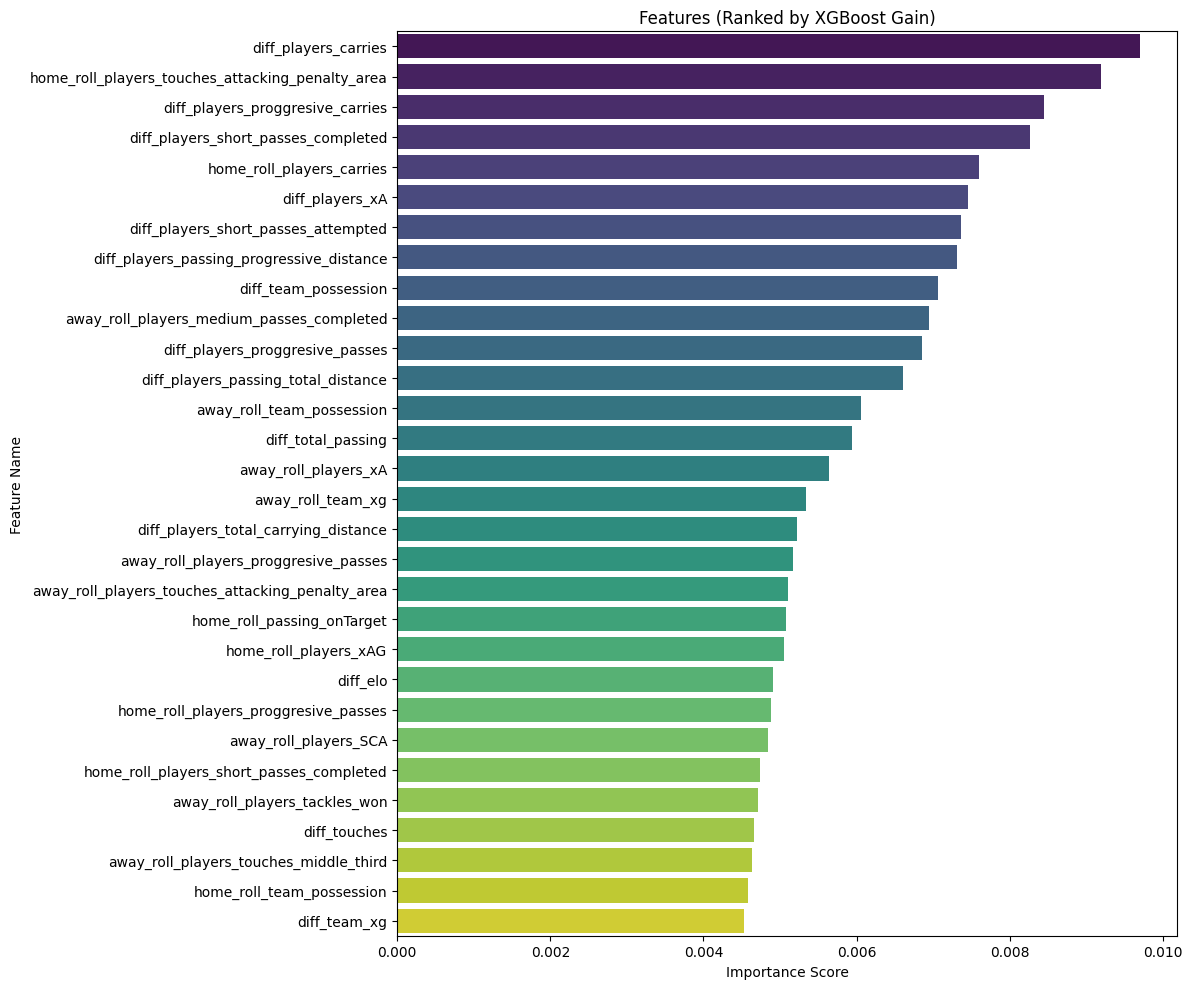

In [4]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print("==================================================")
print("   🔍 FEATURE IMPORTANCE ANALYZER (ROBUST)        ")
print("==================================================")

# 1. Load the Model
try:
    artifacts = joblib.load('football_model_final.pkl')
    model = artifacts['model']
    features = artifacts['features']
    print("✅ Model Loaded.")
except FileNotFoundError:
    print("❌ Error: 'football_model_final.pkl' not found.")
    exit()

# 2. Extract Importances
try:
    # --- NAVIGATION LOGIC ---
    # 1. Get the first fitted CalibratedClassifier from the Cross-Validation list
    calibrated_layer = model.calibrated_classifiers_[0]
    
    # 2. Extract the underlying StackingClassifier
    # Handle Scikit-Learn version differences (estimator vs base_estimator)
    if hasattr(calibrated_layer, 'estimator'):
        stacking_clf = calibrated_layer.estimator
    else:
        stacking_clf = calibrated_layer.base_estimator
    
    # 3. Extract the XGBoost model
    # In your script, XGBoost was the first estimator: estimators=[('xgb', xgb_clf), ...]
    xgb_model = stacking_clf.estimators_[0]
    
    print(f"✅ Extracted Model: {type(xgb_model).__name__}")
    
    # 4. Get Scores
    importances = xgb_model.feature_importances_
    
    # Safety Check
    if len(importances) != len(features):
        print(f"⚠️ Mismatch! Model has {len(importances)} features, but list has {len(features)}.")
        print("Using indices instead of names...")
        feature_names = [f"Feature_{i}" for i in range(len(importances))]
    else:
        feature_names = features

    # Create DataFrame
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\n🏆 PREDICTIVE FEATURES:")
    print(fi_df.head(len(fi_df)).to_string(index=False))
    
    # 6. Check Player Stats
    print("\n🔎 NEW PLAYER STATS PERFORMANCE:")
    player_cols = [c for c in feature_names if 'player' in c or 'SCA' in c or 'xAG' in c]
    player_df = fi_df[fi_df['Feature'].isin(player_cols)]
    
    if not player_df.empty:
        print(player_df.to_string(index=False))
    else:
        print("No player stats found in the feature list.")

    # 7. Visualize
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(30), palette='viridis')
    plt.title('Features (Ranked by XGBoost Gain)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Error extracting features: {e}")
    # Debug info
    try:
        print(f"Object Type: {type(model)}")
        if hasattr(model, 'calibrated_classifiers_'):
            print(f"Calibrated Classifiers: {len(model.calibrated_classifiers_)}")
            print(f"Sub-Object dir: {dir(model.calibrated_classifiers_[0])}")
    except:
        pass